### **SIR Model Parameters Estimation**

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
# from tqdm import tqdm


In [108]:
# ### ------------------- Parameters to Vary ------------------- ###

# # lambda: number of people that a susceptible person interacts with per time step
# # p: probability of getting infected if a susceptible person interacts with an infectious person
# # gamma: recovery rate (recovery probability within one time step)
# gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# ### ------------------- Fixed Parameters ------------------- ###

# # Total population.
# N_NJ = 9288994
# N_NY = 20201249
# N_CA = 39538223
# N_IL = 12812508
# N_PA = 13002700

# # A grid of time points (in days) for the detecting period
# t_set = np.linspace(0, 765, 766)

# # Initial number of infected and immune individuals, I0 and R0.
# I0, R0 = 10, 0

# # Everyone else, S0, is susceptible to infection initially.
# S0_NJ = N_NJ - I0 - R0
# S0_NY = N_NY - I0 - R0
# S0_CA = N_CA - I0 - R0
# S0_IL = N_IL - I0 - R0
# S0_PA = N_PA - I0 - R0

# # The SIR model differential equations.
# def deriv_dynamic(y, t, N, beta, gamma):
#     S, I, R = y
#     dSdt = -beta(t) * S * I / N
#     dIdt = beta(t) * S * I / N - gamma * I
#     dRdt = gamma * I
#     return dSdt, dIdt, dRdt

# x = np.linspace(0, 765, 766)

# r0_gamma = np.array([5, 4, 4, 3, 2, 2, 1, 1, 0.5, 0.5])

# def random_beta(t):
        
#     if t < 36:
#         return r0_gamma[0]
#     if 36 <= t < 72:
#         return r0_gamma[1]
#     if 72 <= t < 108:
#         return r0_gamma[2]
#     if 108 <= t < 144:
#         return r0_gamma[3]
#     if 144 <= t < 180:
#         return r0_gamma[4]
#     if 180 <= t < 216:
#         return r0_gamma[5]
#     if 216 <= t < 248:
#         return r0_gamma[6]
#     if 248 <= t < 284:
#         return r0_gamma[7]
#     if 284 <= t < 320:
#         return r0_gamma[8]
#     if t > 320:
#         return r0_gamma[9]


# ### ----------------- Dynamic Parameters ----------------- ###

# # Initial conditions vector
# y0 = S0, I0, R0
# # Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
# S_syn, I_syn, R_syn = ret.T

# # Plot the data on three separate curves for S(t), I(t) and R(t)
# fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t_set, S_syn/N, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t_set, I_syn/N, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t_set, R_syn/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
# ax.set_xlabel('Time /days')
# ax.set_ylabel('Percentage of Population')
# ax.set_ylim(0,1.2)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
# plt.show()

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.optimize as optimize

In [93]:
# est_R_0 = np.array([0.9] * 26)
# est_R_0 = np.random.normal(2, 0.5, size=(26,))
est_R_0 = np.concatenate((np.random.normal(1, 0.5, size=(13,)), np.random.normal(2, 0.5, size=(13,))), axis=0)
t_set = np.linspace(0, 765, 766)

def loss_func(est_R_0, I_true, type_loss_func, state):
    gamma = 1./14

    N_dict = {
        "NJ": 9288994,
        "NY": 20201249,
        "CA": 39538223,
        "IL": 12812508,
        "PA": 13002700
    }

    N = N_dict[state]
    I0, R0 = 20, 0
    S0 = N - I0 - R0
    y0 = S0, I0, R0
    est_R_0 = np.abs(est_R_0)
    
    def random_beta(t):
        idx = int(t//30)
        idx = 25 if idx > 25 else idx
        idx = 0 if idx < 0  else idx

        return est_R_0[idx] * gamma
    
    def deriv_dynamic(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = - beta(t) * S * I / N
        dIdt = beta(t) * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
    _, I, _ = ret.T
    
    loss = type_loss_func(I_true, I/N)
    
    return loss


In [100]:
N_NJ = 9288994
N_NY = 20201249
N_CA = 39538223
N_IL = 12812508
N_PA = 13002700

with open("NJ.txt") as f:
    string_NJ = f.readline()
NJ_data = np.array(string_NJ.split(",")).astype("float")/N_NJ

with open("NY.txt") as f:
    string_NY = f.readline()
NY_data = np.array(string_NJ.split(",")).astype("float")/N_NY

with open("CA.txt") as f:
    string_CA = f.readline()
CA_data = np.array(string_CA.split(",")).astype("float")/N_CA

with open("IL.txt") as f:
    string_IL = f.readline()
IL_data = np.array(string_IL.split(",")).astype("float")/N_IL

with open("PA.txt") as f:
    string_PA = f.readline()
PA_data = np.array(string_PA.split(",")).astype("float")/N_PA

In [94]:
# NJ
optimzer_mae = optimize.minimize(loss_func, est_R_0, args=(NJ_data, mean_absolute_error, "NJ"), options={'maxiter':1000, 'disp':True})
optimzer_mse = optimize.minimize(loss_func, est_R_0, args=(NJ_data, mean_squared_error, "NJ"), options={'maxiter':1000, 'disp':True})

         Current function value: 0.021447
         Iterations: 3
         Function evaluations: 1038
         Gradient evaluations: 38
         Current function value: 0.001157
         Iterations: 16
         Function evaluations: 1161
         Gradient evaluations: 43


In [95]:
# NJ
r0_pred = np.abs(optimzer_mse.x)

In [96]:
r0_pred


array([1.14277089, 1.18934177, 0.01077381, 0.74549687, 1.19465931,
       1.11464018, 1.15067631, 1.0338036 , 0.97987005, 0.73411038,
       0.19305169, 1.00913316, 1.3605029 , 1.7151832 , 2.18253833,
       1.69235811, 2.11184757, 2.24118052, 1.8259404 , 1.88248783,
       1.54608555, 2.65541725, 2.18438238, 1.892205  , 1.39230626,
       1.87622446])

C:\Users\Claire\anaconda3\envs\decision-analytics\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


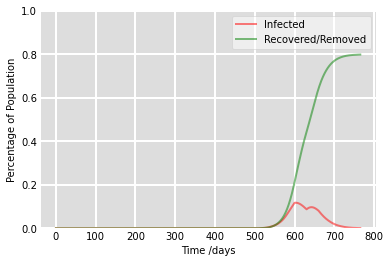

In [97]:
gamma = 1./14
state = "NJ"

N_dict = {
    "NJ": 9288994,
    "NY": 20201249,
    "CA": 39538223,
    "IL": 12812508,
    "PA": 13002700
}

N = N_dict[state]
I0, R0 = 20, 0
S0 = N - I0 - R0
y0 = S0, I0, R0
est_R_0 = np.abs(est_R_0)

def random_beta(t):
    idx = int(t//30)
    idx = 25 if idx > 25 else idx
    idx = 0 if idx < 0  else idx

    return est_R_0[idx] * gamma

def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = - beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
S, I, R = ret.T


fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t_set, S/N_NJ, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N_NJ, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N_NJ, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

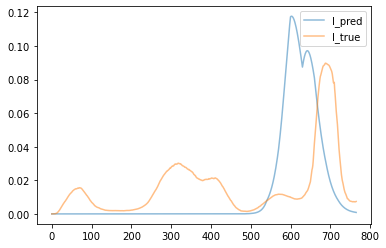

In [98]:
fig, ax = plt.subplots()

ax.plot(list(range(766)), I/N_NJ, label="I_pred", alpha=0.5)
ax.plot(list(range(766)), NJ_data, label="I_true", alpha=0.5)
plt.legend()
plt.show()

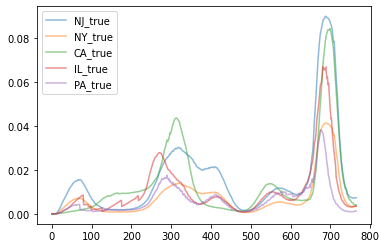

In [105]:
fig, ax = plt.subplots()
ax.plot(list(range(766)), NJ_data, label="NJ_true", alpha=0.5)
ax.plot(list(range(766)), NY_data, label="NY_true", alpha=0.5)
ax.plot(list(range(766)), CA_data, label="CA_true", alpha=0.5)
ax.plot(list(range(766)), IL_data, label="IL_true", alpha=0.5)
ax.plot(list(range(766)), PA_data, label="PA_true", alpha=0.5)
plt.legend()
plt.show()

In [106]:
# ### ------------------- Parameters to Vary ------------------- ###

# # lambda: number of people that a susceptible person interacts with per time step
# # p: probability of getting infected if a susceptible person interacts with an infectious person
# # gamma: recovery rate (recovery probability within one time step)
# gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# ### ------------------- Fixed Parameters ------------------- ###

# # Total population.
# N_NJ = 9288994
# N_NY = 20201249
# N_CA = 39538223
# N_IL = 12812508
# N_PA = 13002700

# # A grid of time points (in days) for the detecting period
# t_set = np.linspace(0, 765, 766)

# # Initial number of infected and immune individuals, I0 and R0.
# I0, R0 = 10, 0

# # Everyone else, S0, is susceptible to infection initially.
# S0 = N - I0 - R0

# # The SIR model differential equations.
# def deriv_dynamic(y, t, N, beta, gamma):
#     S, I, R = y
#     dSdt = -beta(t) * S * I / N
#     dIdt = beta(t) * S * I / N - gamma * I
#     dRdt = gamma * I
#     return dSdt, dIdt, dRdt

# x = np.linspace(0, 367, 368)

# def random_beta(t):
        
#     if t < 36:
#         return r0_pred[0]
#     if 36 <= t < 72:
#         return r0_pred[1]
#     if 72 <= t < 108:
#         return r0_pred[2]
#     if 108 <= t < 144:
#         return r0_pred[3]
#     if 144 <= t < 180:
#         return r0_pred[4]
#     if 180 <= t < 216:
#         return r0_pred[5]
#     if 216 <= t < 248:
#         return r0_pred[6]
#     if 248 <= t < 284:
#         return r0_pred[7]
#     if 284 <= t < 320:
#         return r0_pred[8]
#     if t > 320:
#         return r0_pred[9]

# ### ----------------- Dynamic Parameters ----------------- ###

# # Initial conditions vector
# y0 = S0, I0, R0
# # Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
# S_pred, I_pred, R_pred = ret.T

# # Plot the data on three separate curves for S(t), I(t) and R(t)
# fig = plt.figure(facecolor='w')
# ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.plot(t_set, S_pred/N, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t_set, I_pred/N, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t_set, R_pred/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
# ax.set_xlabel('Time /days')
# ax.set_ylabel('Percentage of Population')
# ax.set_ylim(0,1.2)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
# legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
# plt.show()

In [107]:
# fig, ax = plt.subplots()

# ax.plot(list(range(366)), I_pred, label="I_pred", alpha=0.5)
# ax.plot(list(range(366)), I_syn, label="I_true", alpha=0.5)
# plt.legend()
# plt.show()